In [12]:
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from datasets import ImputationDataset, find_pading

In [8]:
indices = [0,400]
imputation_dataset = ImputationDataset(indices, norm_type='unity', mean_mask_length=3, masking_ratio=0.15)

In [9]:
imputation_loader = DataLoader(imputation_dataset, batch_size=2, shuffle=True)
x, mask, label = next(iter(imputation_loader))

In [10]:
x.shape, mask.shape, label.shape

(torch.Size([2, 40, 35]), torch.Size([2, 40, 35]), torch.Size([2]))

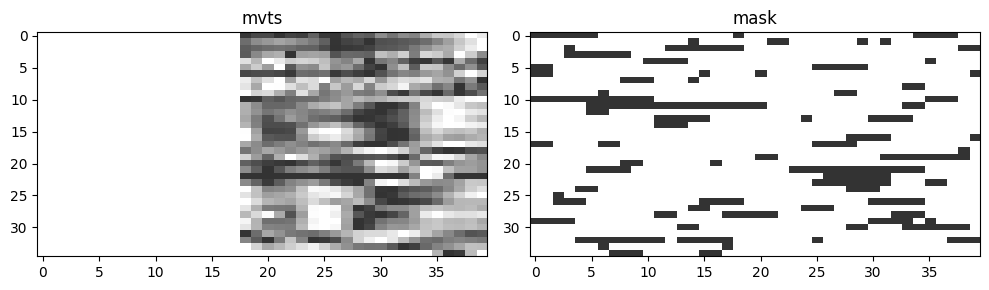

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.set_title('mvts')
ax1.imshow(x[0, :, :].numpy().T, aspect='auto', alpha=0.8, cmap='gray')
ax2.set_title('mask')
ax2.imshow(mask[0, :, :].numpy().T, aspect='auto', alpha=0.8, cmap='gray')
plt.tight_layout()
plt.show()
plt.close()